In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from oneDtoyTask.oneDtoyTask import ToyTask, OneDfield, TwoWayComChannel
from agents.agent_AriaRE import AriaRE
from agents.agent_AriaAC import AriaAC
from IPython import display


In [2]:
epochs = 1000
opt_params = {"lr":0.005, "batch_size":20, "gamma":0.999, "vocab_size":4, "eps":0.01}
agent0 = AriaAC(opt_params=opt_params, with_memory=True, aidi=0).float()
agent1 = AriaAC(opt_params=opt_params, with_memory=True, aidi=1).float()
np.random.seed(1)
field = OneDfield(speed=1)
Task = ToyTask(field=field, observationMappingFct=lambda x: (x>0.5).astype(int), comChannel=TwoWayComChannel())



In [3]:
def plot_preds(obsers, preds):
    display.clear_output(wait=True)
    plt.clf()
    obsers = np.array(obsers)
    preds = np.array(preds)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].plot(obsers[:, 0])
    axs[0].plot(preds[:, 0])
    axs[0].legend(['observations', 'predictions'])
    axs[0].set_title('Agent 0')
    axs[0].set_xlabel('Epoch')

    axs[1].plot(obsers[:, 1])
    axs[1].plot(preds[:, 1])
    axs[1].legend(['observations', 'predictions'])
    axs[1].set_title('Agent 1')
    axs[1].set_xlabel('Epoch')
    plt.grid(True)
    
    display.display(plt.gcf())
    return fig

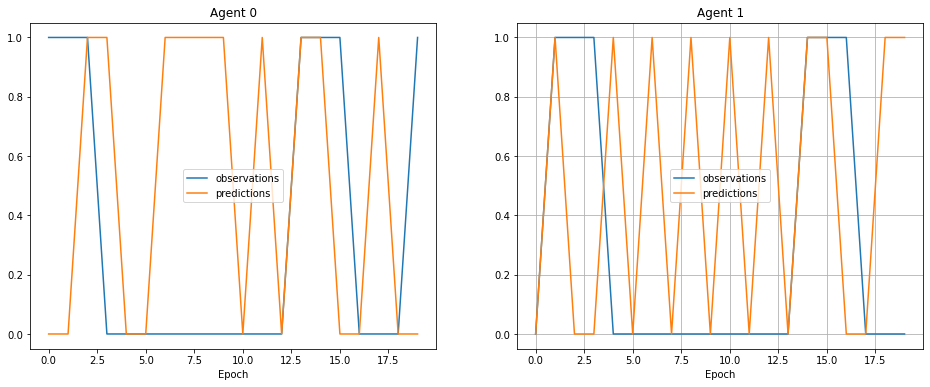

In [4]:
obs, downlink_msgs = Task.reset()
losses = []
rewards1 = []
rewards2 = []
torch.autograd.set_detect_anomaly(True)
epoch = 0
observations = []
predictions = []
while epoch<epochs:
    
    a0, m0u =  agent0.select_action(obs[0], downlink_msgs[0])
    a1, m1u = agent1.select_action(obs[1], downlink_msgs[1])
    mu_ = np.zeros((2, opt_params["vocab_size"]))
    mu_[0, m0u.item()] = 1
    mu_[1, m1u.item()] = 1
    
    predictions.append((a0.item(), a1.item()))
    (obs_, downlink_msgs_), r, done = Task.step([a0.item(), a1.item()], [mu_[0], mu_[1]])
    observations.append([obs_[0][1], obs_[1][0]])
    loss0, rew1, mean_policy0 = agent0.train_on_batch([obs[0], downlink_msgs[0]], r[0])
    loss1, rew2, mean_policy1 = agent1.train_on_batch([obs[1], downlink_msgs[1]], r[1])
    obs = obs_
    downlink_msgs = downlink_msgs_
    if loss0 is not None:
        losses.append([loss0, loss1])
        rewards1.append(rew1)
        rewards1.append(rew2)
        if epoch%5==0:
            fig  = plot_preds(observations, predictions)
        print(f"epoch {epoch}/{epochs} \n[policy loss, value loss, entropy loss], reward:  \nagent 0 {loss0}, {np.mean(rew1)} mean policy {mean_policy0} \nagent 1 {loss1}, {np.mean(rew2)} mean policy {mean_policy1}")
        
        epoch+=1
        observations = []
        predictions = []
        plt.close()